## Image Loading

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images
from sklearn.cluster import KMeans

In [2]:
print(cv2.__version__)
print(np.__version__)

4.7.0
1.23.5


In [3]:
def imshow(image=None, title="sample image", cmap=None):
    plt.imshow(image, cmap=cmap) # cv2.cvtColor(image, cv2.COLOR_BAYER_BG2RGB)
    plt.title(title)
    plt.show()

In [4]:
im1, im2 = load_sample_images().images
im1.shape,\
im2.shape

((427, 640, 3), (427, 640, 3))

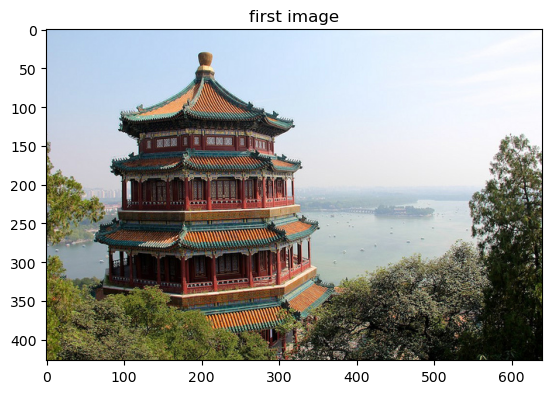

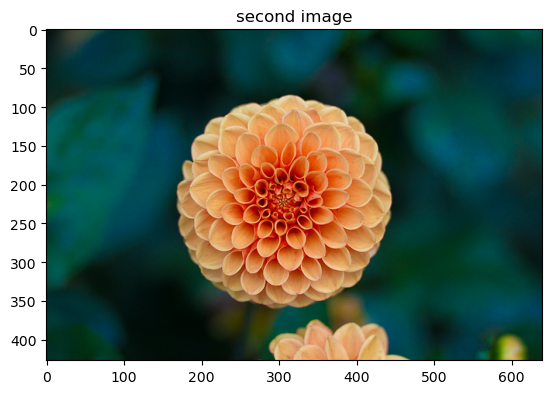

In [5]:
imshow(im1, 'first image')
imshow(im2, 'second image')

## Basic Effects

### Errosion and Dialation 

In [6]:
def effect(image = None, effect = None, gray=False, ret=False, show=True, cmap=None, gray_show=False, k=5):

    label = f"{effect} image"
    kernel = np.ones((k, k))    
    if gray:
        img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        cmap='gray'
        label += ' (gray)' 
        if gray_show: imshow(img, "grayscale image (w/o effect)", cmap=cmap)
        
    if effect == "erode":
        img = cv2.erode(img, kernel)
        if show: imshow(img, label, cmap=cmap)

    elif effect == "dilate":
        img = cv2.dilate(img, kernel)
        if show: imshow(img, label, cmap=cmap)

    elif effect == "opening":
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
        if show: imshow(img, label, cmap=cmap)    

    elif effect == "closing":
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        if show: imshow(img, label, cmap=cmap)

    elif effect == None:
        label = label.replace('None', 'original')
        if show: imshow(img, label, cmap=cmap)

    else:
        print(f'unsupported effect: {effect}')
        if show: imshow(img, label, cmap=cmap)

    if ret:
        return img

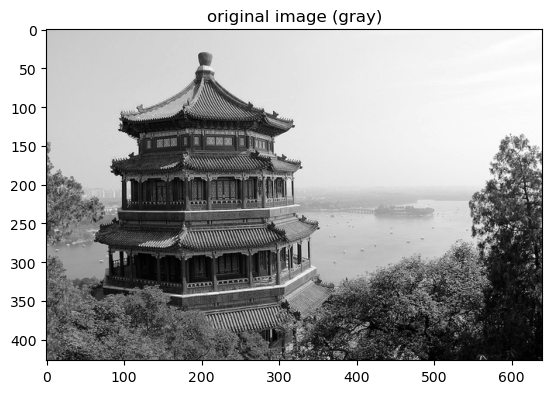

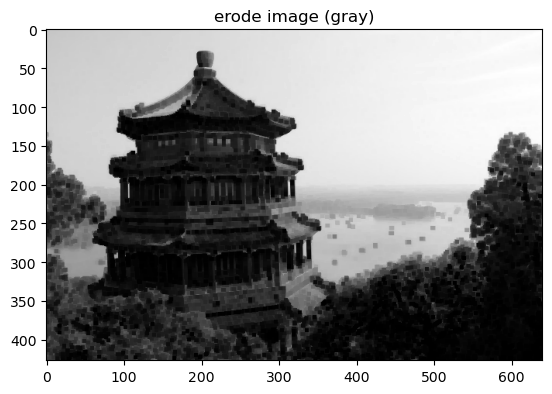

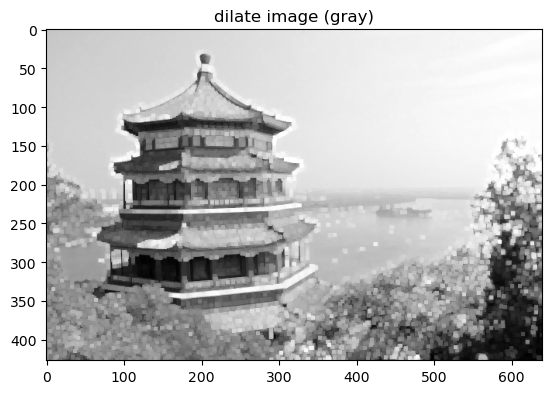

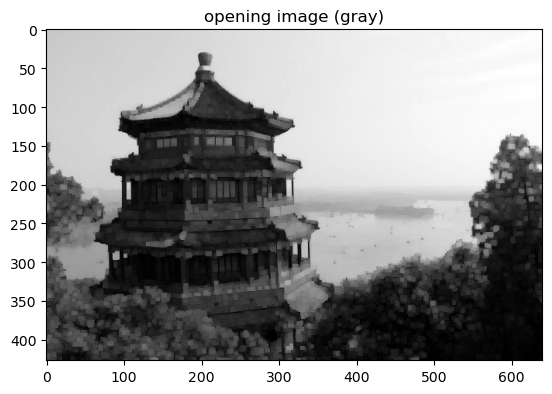

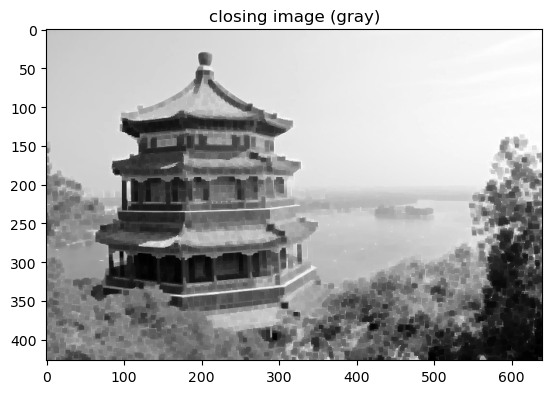

In [7]:
effect(im1, gray= True)
effect(im1, 'erode', gray= True)
effect(im1, 'dilate', gray= True)
effect(im1, 'opening', gray= True)
effect(im1, 'closing', gray= True)

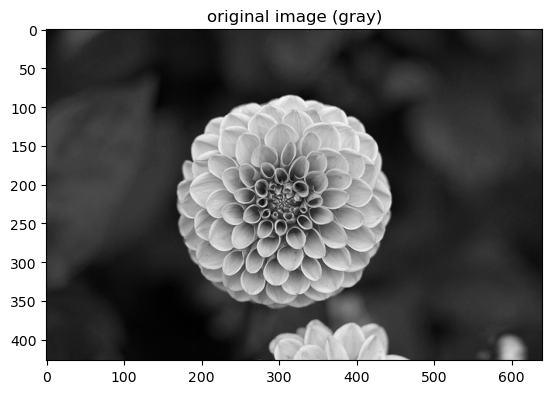

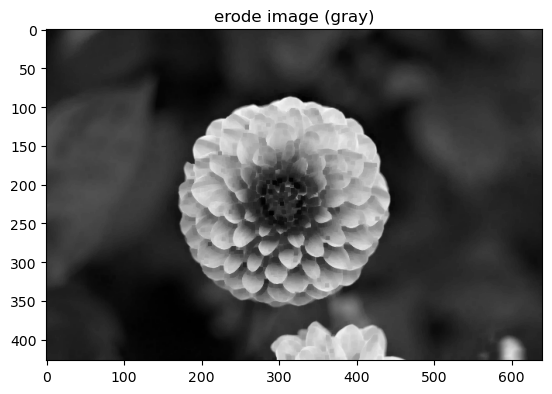

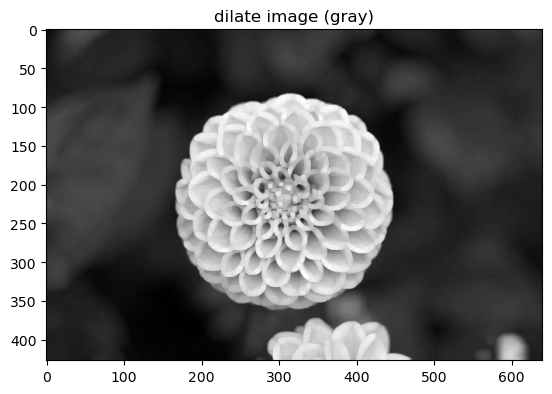

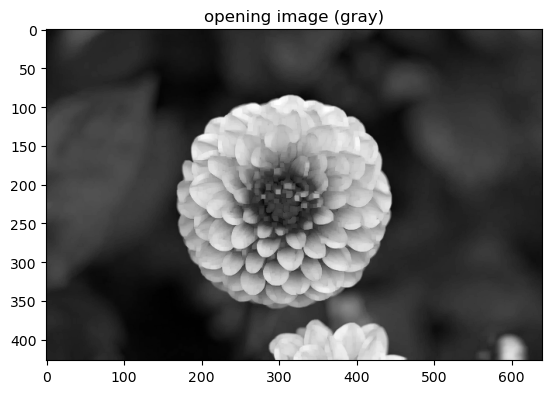

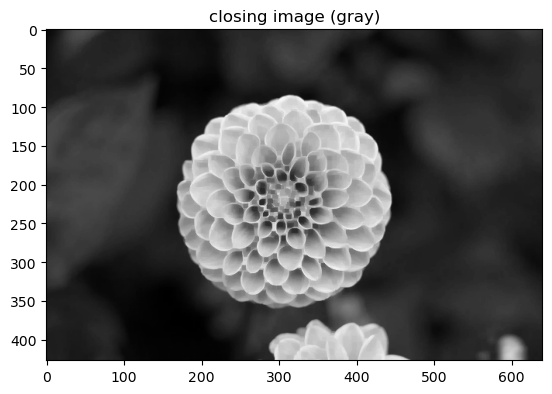

In [8]:
effect(im2, gray= True)
effect(im2, 'erode', gray= True)
effect(im2, 'dilate', gray= True)
effect(im2, 'opening', gray= True)
effect(im2, 'closing', gray= True)

### Canny Edge Detection

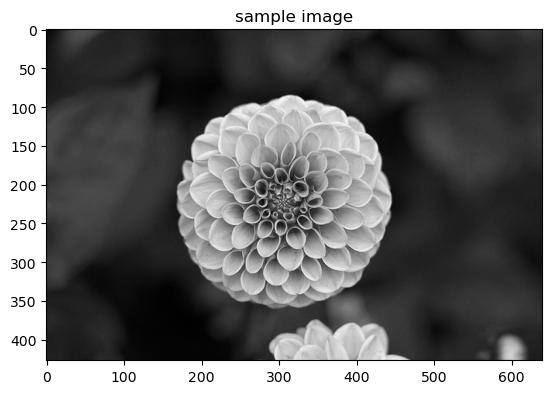

In [9]:
imshow(effect(im2, gray=True, show=False, ret=True), cmap='gray')

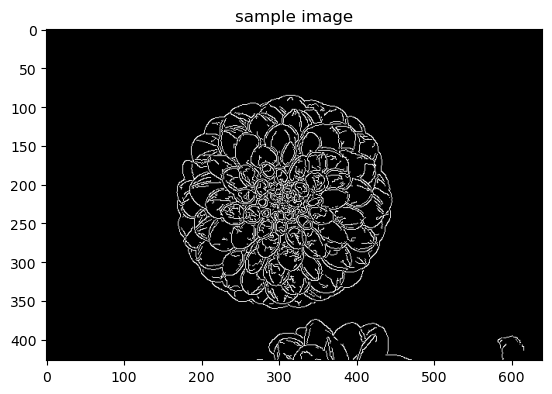

In [10]:
imshow(cv2.Canny(effect(im2, gray=True, show=False, ret=True), 50, 120), cmap='gray')

In [11]:
# source: https://pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/

def auto_canny(image, sigma=0.33, blur=False):
     # compute the median of the single channel pixel intensities
     v = np.median(image)
     if blur: image = cv2.blur(image, (5,5))

     # apply automatic Canny edge detection using the computed median
     lower = int(max(0, (1.0 - sigma) * v))
     upper = int(min(255, (1.0 + sigma) * v))
     edged = cv2.Canny(image, lower, upper)

     # return the edged image
     return edged

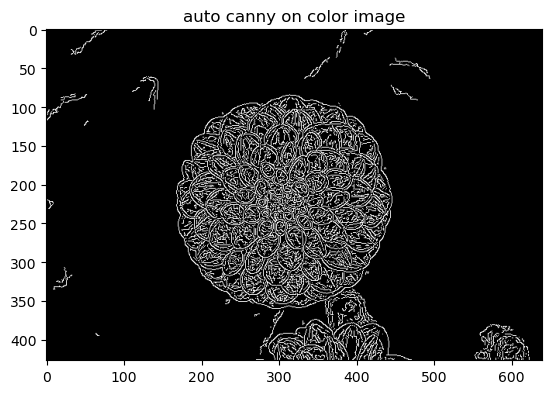

In [12]:
img = auto_canny(im2)
imshow(img, "auto canny on color image", cmap='gray')

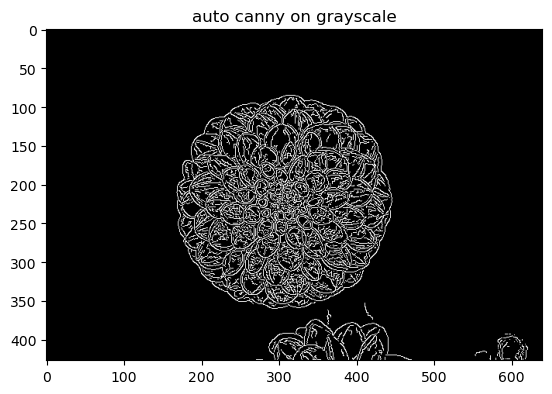

In [13]:
gray_img = effect(im2, gray=True, show=False, ret=True)
img = auto_canny(gray_img)
imshow(img, "auto canny on grayscale", cmap='gray')

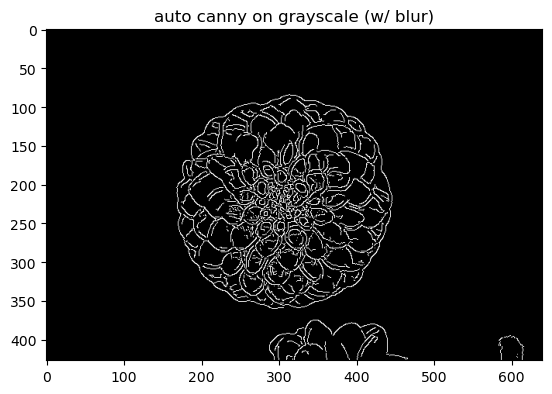

In [14]:
gray_img = effect(im2, gray=True, show=False, ret=True)
img = auto_canny(gray_img, blur=True)
imshow(img, "auto canny on grayscale (w/ blur)", cmap='gray')

displaying blurred auto canny edged onto of original image

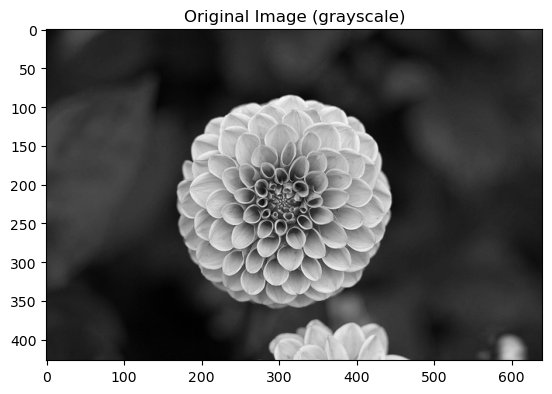

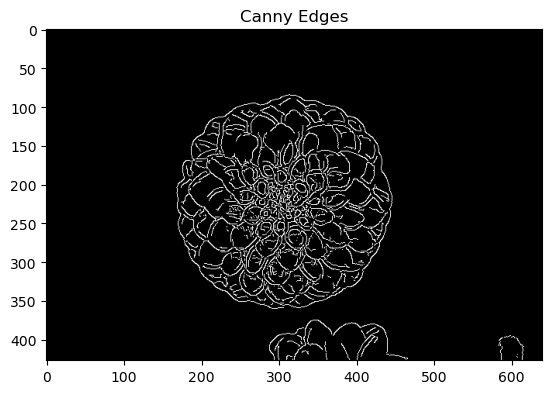

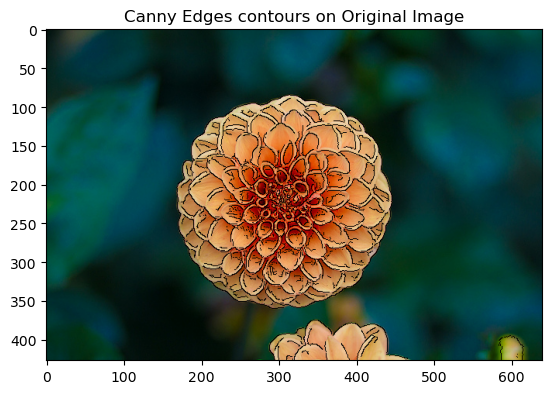

In [15]:
org_img = im2.copy()
gray_org_img = effect(im2, gray=True, show=False, ret=True)
mask_edges = img

imshow(gray_org_img, 'Original Image (grayscale)', 'gray')
imshow(mask_edges, 'Canny Edges', 'gray')

contours, hierarchy = cv2.findContours(mask_edges.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) #SIMPLE)

cv2.drawContours(org_img, contours, -1, (0,0,0), 1)
imshow(org_img, 'Canny Edges contours on Original Image') #, cmap='gray')

## Color Distribution

### Histogram

In [16]:
def color_hist(img, cv=False):

    if cv:
        color = ('b', 'g', 'r')

        for i, col in enumerate(color):
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            plt.plot(hist, color=col)
            plt.xlim([0,256])

        plt.show()
        
    else:    
        plt.hist(img.ravel(), 256, [0, 256])
        plt.show()

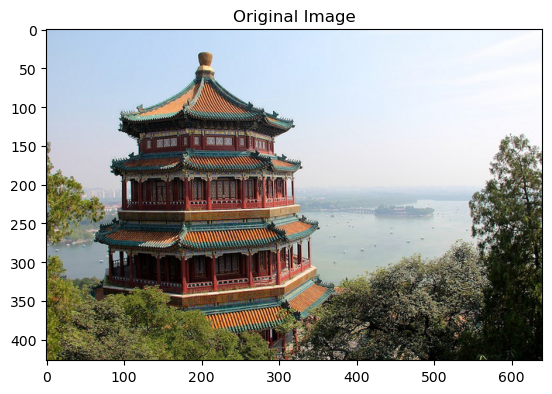

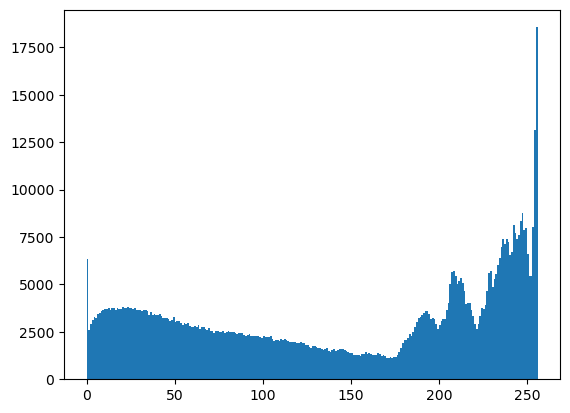

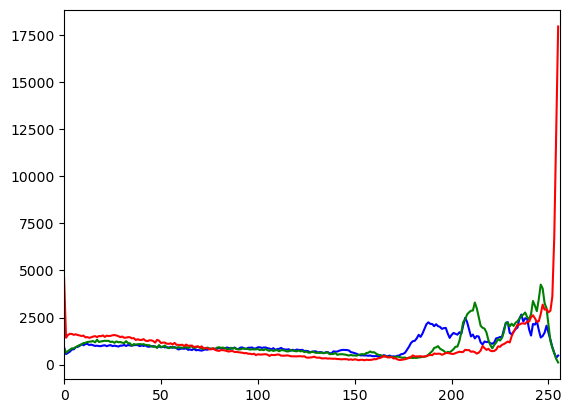

In [17]:
imshow(im1, 'Original Image')
color_hist(im1)
color_hist(im1, cv=True)

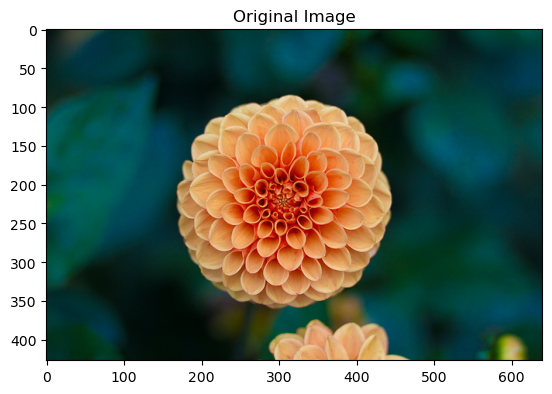

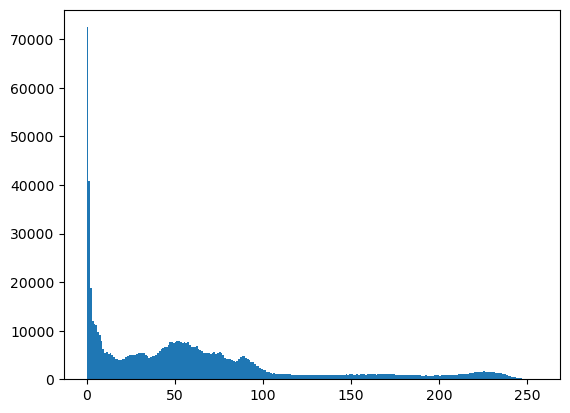

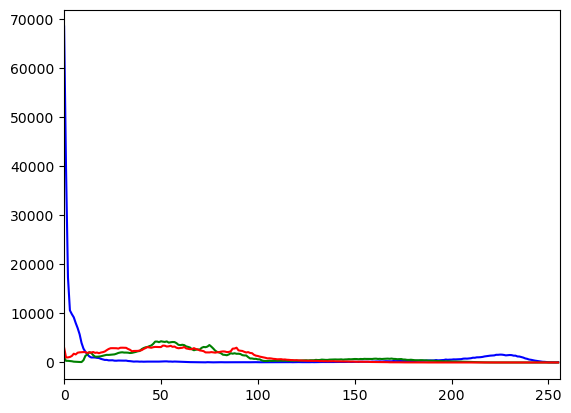

In [18]:
imshow(im2, 'Original Image')
color_hist(im2)
color_hist(im2, cv=True)

### K-Mean Clustering

In [22]:
def centroid_hist(clt):    
    # create bar labels of cluster count length
    nlabels = np.arange(0, len(np.unique(clt.labels_)) + 1)

    (hist, _) = np.histogram(clt.labels_, bins = nlabels)

    hist = hist.astype('float')
    hist /= hist.sum()

    # individual color centroid pixel values
    centroids = clt.cluster_centers_

    # create empty barchart
    min, max = 100, 500
    bar = np.zeros((min, max, 3), dtype = 'uint8')

    x_start = 0
    for (percent, color) in zip(hist, centroids):
        end = x_start + (percent * max)
        cv2.rectangle(bar, (int(x_start), 0), (int(end), 100),
                      color.astype('uint8').tolist(),  thickness=-1)
        x_start = end

    return bar

def fit_cluster(img, k=5):
    '''fits k clusters on pixels of all the image channels of the image img
    return the fitted cluster model'''

    h, w = img.shape[0], img.shape[1]
    img = img.reshape((h*w, 3))

    clt = KMeans(k, n_init='auto')
    clt.fit(img)

    return clt

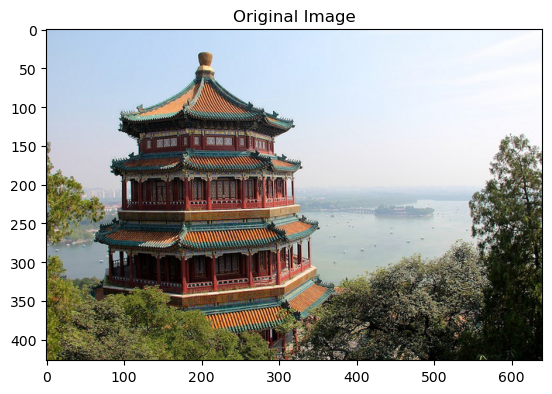

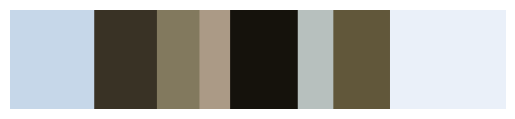

In [23]:
imshow(im1, 'Original Image')
clt = fit_cluster(im1, k=8)
bar = centroid_hist(clt)

plt.figure()
plt.axis('off')
plt.imshow(bar)
plt.show()

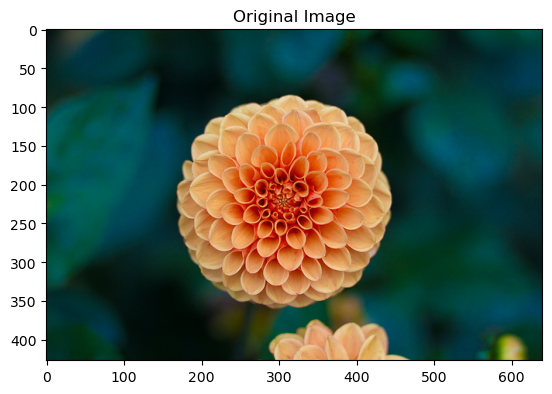

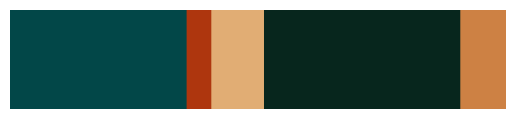

In [24]:
imshow(im2, 'Original Image')
clt = fit_cluster(im2)
bar = centroid_hist(clt)

plt.figure()
plt.axis('off')
plt.imshow(bar)
plt.show()